In [69]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn.functional as F
from torch.autograd import Variable as Var

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
% run "./treelstm/utils"
pd.set_option('display.max_colwidth', 1000)

In [91]:
saved_model = torch.load('checkpoints/rnn-question-answering-similarity,epoch=3.pt')
trainer = saved_model['trainer']
test_dataset = torch.load('data/lc-quad/pth/lc_quad_test.pth')

In [105]:
templates = [1, 101, 102, 103, 105, 106, 11, 111, 15, 151, 16, 2, 3, 5, 6, 7, 8]
df_acc = pd.DataFrame(0, index=np.arange(len(templates)), columns=templates)
df_acc.index = templates

df_tot = pd.DataFrame(0, index=np.arange(len(templates)), columns=templates)
df_tot.index = templates

In [106]:
trainer.model.eval()
trainer.test_embeddings()

y_true = []
y_pred = []
output_vocab = trainer.vocabs['output']

for index in range(len(test_dataset)):
    torch.no_grad()
    
    l_input, r_input, label = test_dataset[index]
    
    _, _, _, _, ltemplate = l_input
    _, _, _, _, rtemplate = r_input
    
    ltemplate = int(ltemplate)
    rtemplate = int(rtemplate)
    
    ltree, linput = trainer._get_data(l_input)
    rtree, rinput = trainer._get_data(r_input)

    target = Var(map_label_to_target(label, test_dataset.num_classes))
    output = trainer.model(ltree, linput, rtree, rinput)
    
    output = output.squeeze().to('cpu')
    pred = int(torch.argmin(output))
    
    if pred == 1:
        df_acc[ltemplate][rtemplate] += 1
    
    df_tot[ltemplate][rtemplate] += 1

In [107]:
df_acc

,1,101,102,103,105,106,11,111,15,151,16,2,3,5,6,7,8
1,2,0,0,0,0,0,0,0,0,1,1,2,1,4,1,0,0
101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
111,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
15,1,0,0,0,0,0,0,0,2,0,2,0,1,0,0,0,1
151,0,0,0,0,0,0,0,0,0,5,1,2,0,0,0,0,0


In [108]:
df_tot

,1,101,102,103,105,106,11,111,15,151,16,2,3,5,6,7,8
1,23,5,0,0,11,3,8,2,14,22,17,29,12,27,11,5,11
101,5,1,0,0,4,1,1,1,2,4,2,7,7,14,5,3,5
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,7,6,0,0,3,0,3,3,6,12,10,19,12,18,6,2,7
106,2,0,0,0,2,1,0,1,1,6,3,6,1,8,3,1,2
11,2,1,0,0,3,1,0,1,4,4,4,4,1,8,2,0,0
111,3,2,0,0,2,0,0,1,2,3,8,4,3,6,2,1,1
15,6,2,0,0,2,1,2,2,5,5,4,12,6,18,5,1,3
151,22,6,0,0,4,0,5,1,4,10,22,24,15,18,7,3,8


In [109]:
df_cm = df_acc / df_tot

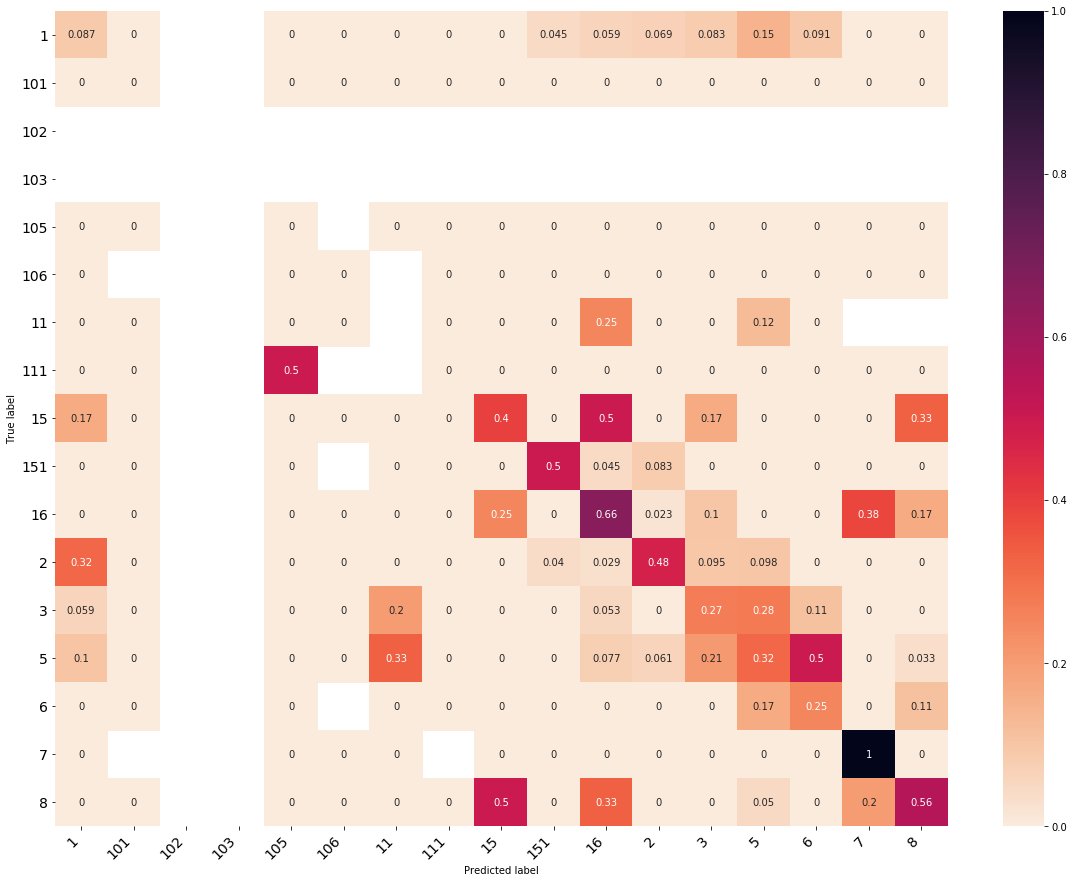

In [110]:
class_names = templates

fig = plt.figure(figsize=(20, 15))
cmap = sns.cm.rocket_r
heatmap = sns.heatmap(df_cm, annot=True, cmap=cmap)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix.png')
plt.show()